# Local Sums



## Local Sums in arbitrary categories

We defined local sums in arbitrary categories. 
The requirement we have is that addition distributes over composition.
First we define some objects and arrows:

In [12]:
from discopy.cat import LocalSum, Ob, Box, Arrow
from typing import List, Callable

x, y, z = Ob('x'), Ob('y'), Ob('z')
f = Box('f', x, y)
g = Box('g', x, y)
h = Box('h', y, z)


We can add boxes as follows and then compose them on both sides:

In [13]:
fg = LocalSum([f, g]) 
print("This is the sum:", fg)
k = fg >> h
print("With composition from the right:", k)
l= Box("h'", z, x) >> fg
print("With composition from the left:", l)

This is the sum:  ((f) + (g)) 
With composition from the right:  ((f) + (g))  >> h
With composition from the left: h' >>  ((f) + (g)) 


The addition does distribute over composition. You can distribute to the left and to the right.
This implementation is neither memory efficient nor very nice to look at.
But it seems to work for now.

In [14]:
def distribute_composition(arrow: Arrow, index_sum: int, distribute_up_to: int, arrow_construction=lambda dom,cod,boxes: Arrow(dom,cod,boxes), localsum_type=LocalSum) -> Arrow:
    """
    Distributes the sum at index_sum to the left with

    Parameters
    ----------
    arrow: Arrow
        The arrow to perform the operation on
    index_sum: int
        The index of the sum to distribute for
    distribute_up_to: int
        index of the last term to distribute
    arrow_construction: callable
        callable returning the arrow equivalent in the relevant category    

    Raises
    ------
      IndexError: The index of sum does not correspond to a box or distribute_up_to is negative or to large
      TypeError: The box at index_sum does not have type sum
    """
    if len(arrow.boxes) <= index_sum or index_sum < 0:
        raise IndexError("index to large or negative, no such box")
    if (
        len(arrow.boxes) <= distribute_up_to
        or distribute_up_to < 0
        or distribute_up_to == index_sum
    ):
        raise IndexError(
            "distribute_up_to to large, negative or equal to index_sum, no such box"
        )
    if not isinstance(arrow.boxes[index_sum], LocalSum):
        raise TypeError("box at index %d is not a LocalSum", index_sum)

    if index_sum < distribute_up_to:
        # distribute to the right
        unit = arrow.boxes[index_sum].__class__(
            [], arrow.boxes[index_sum].dom, arrow.boxes[distribute_up_to].cod
        )
        terms = [
            g.then(arrow_construction(arrow.boxes[index_sum + 1].dom, arrow.boxes[distribute_up_to].cod, arrow.boxes[index_sum + 1:distribute_up_to + 1]))
            for g in arrow.boxes[index_sum].terms
        ]
        term = arrow.boxes[index_sum].upgrade(localsum_type(terms))
        new_boxes = arrow.boxes[:index_sum] + [term] + arrow.boxes[distribute_up_to + 1 :]
        return arrow_construction(
            new_boxes[0].dom,
            new_boxes[-1].cod,
            new_boxes,
        )
    else:
        # distribute to the left
        unit = arrow.boxes[index_sum].__class__(
            [], arrow.boxes[distribute_up_to].dom, arrow.boxes[index_sum].cod
        )
        terms = [
            arrow_construction(arrow.boxes[distribute_up_to].dom, arrow.boxes[index_sum-1].cod, arrow.boxes[distribute_up_to:index_sum]).then(g)
            for g in arrow.boxes[index_sum].terms
        ]
        term = arrow.boxes[index_sum].upgrade(localsum_type(terms))
        new_boxes = arrow.boxes[:distribute_up_to] + [term] + arrow.boxes[index_sum + 1 :]
        return arrow_construction(
            new_boxes[0].dom,
            new_boxes[-1].cod,
            new_boxes,
        )


print(distribute_composition(l, 1, 0))
print(distribute_composition(k, 0, 1))


 ((h' >> f) + (h' >> g)) 
 ((f >> h) + (g >> h)) 


This also works for larger arrows, where we do not want to distribute the entire way and in both directions:

In [15]:
diag = Box("a", x, y) >> Box("b", y, x) >> LocalSum([Box("c", x, z), Box("d", x, z)]) >> Box("e", z, y)>> Box("f", y, y)>> Box("g", y, x)
print(diag)
print(distribute_composition(diag, 2, 1))
print(distribute_composition(diag, 2, 4))

a >> b >>  ((c) + (d))  >> e >> f >> g
a >>  ((b >> c) + (b >> d))  >> e >> f >> g
a >> b >>  ((c >> e >> f) + (d >> e >> f))  >> g


Undoing distribution is not supported directly, since for this to work all terms of the sum need to have some part in common.
So we use this method for reverting the distribution. 

In [16]:
# TODO: actually build the thing

## Local Sums in monoidal categories

For categories with a monoidal structure the addition will distribute over the monoidal product iff the category admits arbitrary biproducts.
We basically have that for arrows $A,B,C$ we get $A \otimes (B + C) = (A \otimes B ) + (A \otimes C)$

If this is given one may use the following function to pull parts of the diagram in and out of a sum.



In [17]:
from discopy.monoidal import LocalSum, Ob, Box, Diagram, Ty, Id

x, y, z = Ty('x'), Ty('y'), Ty('z')
f = Box('f', x, y)
g = Box('g', x, y)
h = Box('h', y, z)

 ((f) + (g))  @ Id(y) >> Id(y) @ h
 ((f) + (g))  @ Id(y) >> Id(y) @ h
[LocalSum([Box('f', Ty('x'), Ty('y')), Box('g', Ty('x'), Ty('y'))]), Box('h', Ty('y'), Ty('z'))]
y @ z
f @ Id(x @ y @ x) >> Id(y) @  ((f) + (g))  @ Id(y @ x) >> Id(y @ y) @ h @ Id(x) >> Id(y) @ t @ Id(x) >> Id(y) @ f @ Id(x) >> Id(y @ y) @ g


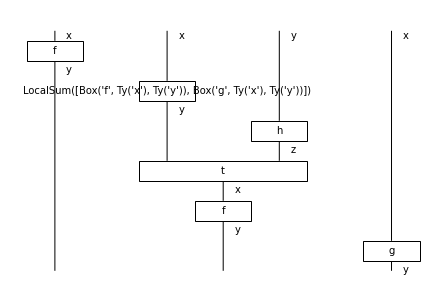

[Box('f', Ty('x'), Ty('y')), LocalSum([Diagram(dom=Ty('x', 'y'), cod=Ty('y', 'z'), boxes=[Box('f', Ty('x'), Ty('y')), Box('h', Ty('y'), Ty('z'))], offsets=[0, 1]), Diagram(dom=Ty('x', 'y'), cod=Ty('y', 'z'), boxes=[Box('g', Ty('x'), Ty('y')), Box('h', Ty('y'), Ty('z'))], offsets=[0, 1])]), Box('t', Ty('y', 'z'), Ty('x')), Box('f', Ty('x'), Ty('y')), Box('g', Ty('x'), Ty('y'))]


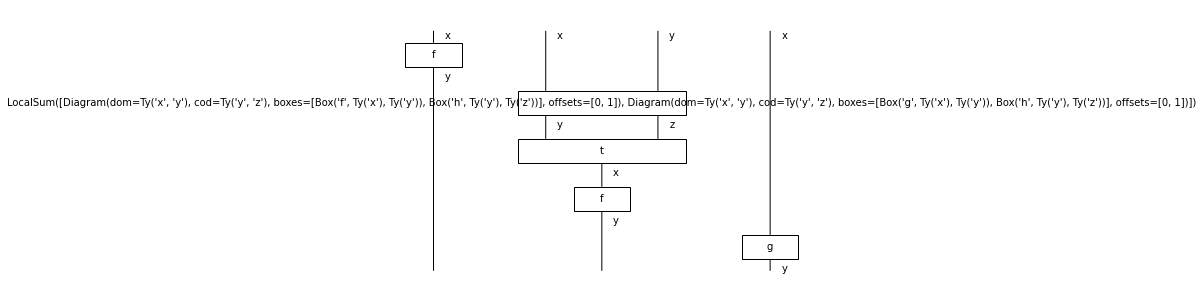

In [18]:
from discopy import rewriting


def distribute_tensor(
    diagram: Diagram, index_sum: int, index_of_partner: int
) -> Diagram:
    """
    Distributes the sum at index_sum to the left with

    Parameters
    ----------
    arrow: Arrow
        The arrow to perform the operation on
    index_sum: int
        The index of the sum to distribute for
    index_of_partner: int
        index of the term to distribute

    Raises
    ------
      IndexError: The index of sum does not correspond to a box or index_of_partner is negative or to large
      TypeError: The box at index_sum does not have type sum
    """
    if len(diagram.boxes) <= index_sum or index_sum < 0:
        raise IndexError("invalid index_sum")
    if len(diagram.boxes) <= index_of_partner or index_of_partner < 0:
        raise IndexError("invalid index_of_partner")
    if index_of_partner == index_sum:
        raise IndexError("cannot distribte over itself")
    if not isinstance(diagram.boxes[index_sum], LocalSum):
        raise TypeError("box at index_sum not LocalSum")
    if abs(index_sum - index_of_partner) != 1:
        raise IndexError(
            "at the moment distributing is only supported when the boxes are next to one another"
        )

    layers_index = list(
        range(
            diagram.offsets[index_sum],
            diagram.offsets[index_sum] + len(diagram.boxes[index_sum].dom.objects),
        )
    )
    layers_partner = list(
        range(
            diagram.offsets[index_of_partner],
            diagram.offsets[index_of_partner]
            + len(diagram.boxes[index_of_partner].dom.objects),
        )
    )

    if index_sum < index_of_partner:
        if min(layers_index) < min(layers_partner) and max(layers_index) >= min(
            layers_partner
        ):
            raise IndexError("the layers overlap! we cannot distribute")

        if min(layers_index) > min(layers_partner) and max(layers_index) <= min(
            layers_partner
        ):
            raise IndexError("the layers overlap! we cannot distribute")

    if layers_index[0] < layers_partner[0]:
        # tensor from the right
        new_terms = (
            diagram.boxes[: min(index_sum, index_of_partner)]
            + [
                LocalSum(
                    [
                        f.tensor(diagram.boxes[index_of_partner])
                        for f in diagram.boxes[index_sum].terms
                    ]
                )
            ]
            + diagram.boxes[max(index_sum, index_of_partner) +1:]
        )
    else:
        # tensor from the left
        new_terms = (
            diagram.boxes[: min(index_sum, index_of_partner)]
            + [
                LocalSum(
                    [
                        diagram.boxes[index_of_partner].tensor(f)
                        for f in diagram.boxes[index_sum].terms
                    ]
                )
            ]
            + diagram.boxes[max(index_sum, index_of_partner)+1 :]
        )
    new_offsets = (
        diagram.offsets[: min(index_sum, index_of_partner)]
        + [min(layers_index[0], layers_partner[0])]
        + diagram.offsets[max(index_sum, index_of_partner) +1 :]
    )
    print(new_terms)
    return Diagram(diagram.dom, diagram.cod, new_terms, new_offsets)


diag = LocalSum([f, g]) @ h
print(diag)
print(diag.layers)
print(diag.boxes)
print(diag.cod)
diag = f @ (diag >> Box("t", y @ z, x) >> f) @ g
print(diag)
diag.draw()
diag = distribute_tensor(diag, 1, 2)

diag.draw()


Unfortunatly as of now drawing does not work correctly, as you may have noticed above and can again see below:

a >> b >>  ((c) + (d))  >> e >> f >> g


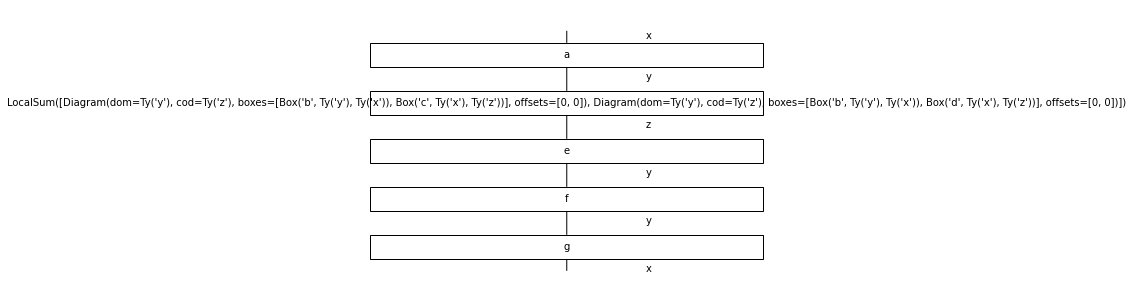

In [19]:
diag = Box("a", x, y) >> Box("b", y, x) >> LocalSum([Box("c", x, z), Box("d", x, z)]) >> Box("e", z, y)>> Box("f", y, y)>> Box("g", y, x)
print(diag)
distribute_composition(diag, 2, 1, arrow_construction=lambda dom,cod,boxes: Diagram(dom, cod,boxes, [0]*len(boxes)), localsum_type=LocalSum).draw()